In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
import pandas as pd
import plotly.graph_objs as go
import tensorflow as tf
from keras.models import Sequential
from keras.utils import to_categorical

from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
import plotly.express as px

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/autoencoder/hogdata.csv


In [7]:
imgSize=64
np.set_printoptions(suppress=True)
df = pd.read_csv('../input/cxrtohog/hogdata.csv')

In [8]:
class MyCallBack(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.999):
            print("Overfit")
            self.model.stop_training=True
            
callbacks=MyCallBack()
from keras.callbacks import ModelCheckpoint

In [9]:
from sklearn.preprocessing import label_binarize
X = df.drop('3780', axis=1).to_numpy()
y = df['3780'].to_numpy()
le = LabelEncoder()
le.fit(y)
print(list(le.classes_))
y=le.transform(y)
y = label_binarize(y, classes=[0, 1, 2])
X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y,test_size=.1,shuffle=True, random_state=1)

['covid', 'normal', 'pneumonia']


In [10]:
X_train=X_train.reshape(X_train.shape[0],60,63,1)
X_test=X_test.reshape(X_test.shape[0],60,63,1)

model=tf.keras.models.Sequential(
[
    tf.keras.layers.Conv2D(32, kernel_size=(3,3),kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='relu', padding='same',input_shape=(60,63,1)),
    tf.keras.layers.MaxPooling2D(pool_size=(3,3)),
    tf.keras.layers.Conv2D(8, kernel_size=(3,3), kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(3,3)),
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(3, activation=tf.nn.softmax)
])

model.compile(optimizer=tf.optimizers.Adam(),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

filepath="./best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


history=model.fit(X_train,y_train, epochs=100, batch_size=50,callbacks=[callbacks,checkpoint],validation_data=(X_test, y_test))

Epoch 1/100
116/116 [==============================] - ETA: 0s - loss: 1.9214 - accuracy: 0.6605
Epoch 00001: val_accuracy improved from -inf to 0.66460, saving model to ./best.hdf5
116/116 [==============================] - 1s 7ms/step - loss: 1.9214 - accuracy: 0.6605 - val_loss: 1.0520 - val_accuracy: 0.6646
Epoch 2/100
116/116 [==============================] - ETA: 0s - loss: 0.8511 - accuracy: 0.7021
Epoch 00002: val_accuracy improved from 0.66460 to 0.80124, saving model to ./best.hdf5
116/116 [==============================] - 1s 5ms/step - loss: 0.8511 - accuracy: 0.7021 - val_loss: 0.6651 - val_accuracy: 0.8012
Epoch 3/100
105/116 [==========================>...] - ETA: 0s - loss: 0.6656 - accuracy: 0.7950
Epoch 00003: val_accuracy improved from 0.80124 to 0.80745, saving model to ./best.hdf5
116/116 [==============================] - 1s 5ms/step - loss: 0.6641 - accuracy: 0.7975 - val_loss: 0.6506 - val_accuracy: 0.8075
Epoch 4/100
104/116 [=========================>....] - 

In [11]:
model.load_weights("best.hdf5")

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 63, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 21, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 21, 8)         2312      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 7, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 336)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               43136     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0

In [13]:
model.evaluate(X_test,y_test,batch_size=5)

129/129 [==============================] - 0s 2ms/step - loss: 0.3463 - accuracy: 0.9379


[0.3462969958782196, 0.9378882050514221]

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'right_bottom'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


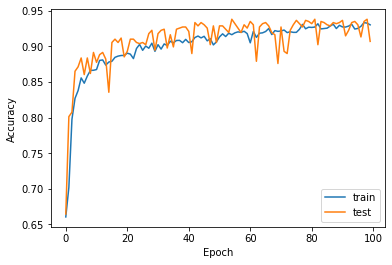

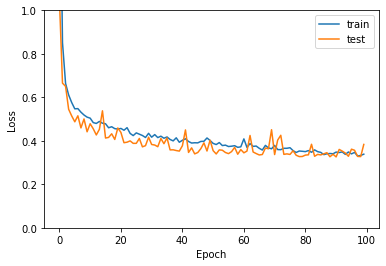

In [14]:
# Visualize training history
import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='right_bottom')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(0.0, 1.0)
plt.legend(['train', 'test'], loc='best')
plt.show()

In [15]:
from sklearn.metrics import confusion_matrix
y_pred=model.predict_classes(X_test, verbose=0)
y_test1=np.argmax(y_test, axis=1)
confusion_matrix(y_test1,y_pred)

array([[ 47,   4,   7],
       [  1, 146,  11],
       [  3,  14, 411]])

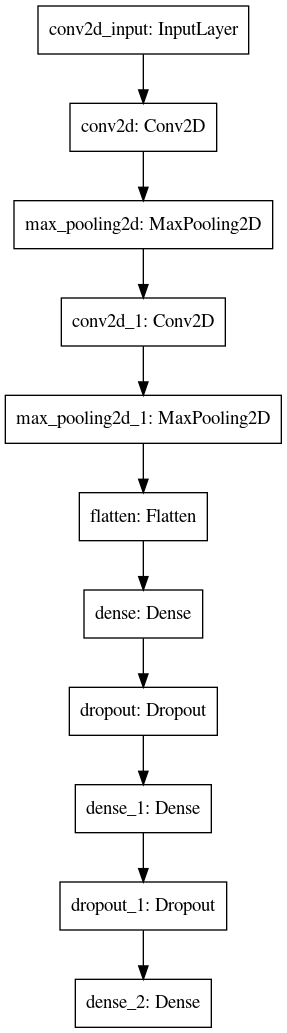

In [16]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [17]:
y_score=model.predict(X_test, verbose=1)

21/21 [==============================] - 0s 2ms/step


In [18]:
clas=['Covid-19', 'Normal', 'Pneumonia']

https://www.dlology.com/blog/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier/

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


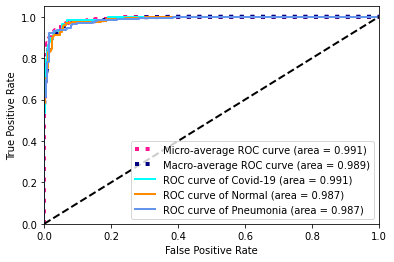

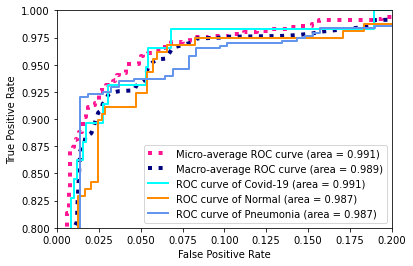

In [19]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc

# Plot linewidth.
lw = 2
n_classes=3
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='Micro-average ROC curve (area = {0:0.3f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='Macro-average ROC curve (area = {0:0.3f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of {0} (area = {1:0.3f})'
             ''.format(clas[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='Micro-average ROC curve (area = {0:0.3f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='Macro-average ROC curve (area = {0:0.3f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of {0} (area = {1:0.3f})'
             ''.format(clas[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()